0. Package Installation

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import time
import re

In [2]:
from utils.imageloader import load_images
from utils.save_image import save_image
from utils.dataloader import load_data
from utils.normalize import batch_normalize
from utils.gram_matrix import gram_matrix
from model.VGG16 import VGG16
from model.TransformerNet import TransformerNet

1. Hyperparameter Setting

In [3]:
batch_size = 8
num_epoch = 50
learning_rate = 1e-4
content_weight = 1e5
style_weight = 1e10
log_interval = 200
ckpt_dir = './checkpoints'
season1 = 'summer'
season2 = 'fall'
method = 'shake_feature' # 'one_season', 'shake_data', 'shake_feature'

2. Style Images and Train Data Loading

In [4]:
if(method == 'one_season' and season1 == season2):
    season = season1
    style_data = load_images('./data/', season)
elif(method == 'shake_data' and season1 != season2):
    season = season1 + '_' + season2 + '_data'
    style_data1 = load_images('./data/', season1)
    style_data2 = load_images('./data/', season2)
    idx1 = np.random.choice(10, 5)
    idx2 = np.random.choice(10, 5)
    style_data = torch.stack([style_data1[i] for i in idx1] + [style_data2[i] for i in idx2],0)
elif(method == 'shake_feature' and season1 != season2):
    season = season1 + '_' + season2 + '_feature'
    style_data1 = load_images('./data/', season1)
    style_data2 = load_images('./data/', season2)
    style_data = style_data1
else:
    season = season1
    style_data = load_images('./data/', season)
print(style_data.shape)

train_dataset, train_dataloader, val_dataset, val_dataloader = load_data('./data/', batch_size)
print(train_dataset[0][0].shape)
print(len(train_dataset), len(val_dataset))

torch.Size([10, 3, 256, 256])
torch.Size([3, 256, 256])
4000 1000


3. Style Transform with gram

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
transformer = TransformerNet()
vgg = VGG16(requires_grad=False).to(device)

C:\Users\jeongmin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jeongmin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
if(method == 'one_season' and season1 == season2):
    features_style = vgg(batch_normalize(style_data.to(device)))
    gram_style = [gram_matrix(y) for y in features_style]
elif(method == 'shake_data' and season1 != season2):
    features_style = vgg(batch_normalize(style_data.to(device)))
    gram_style = [gram_matrix(y) for y in features_style]
elif(method == 'shake_feature' and season1 != season2):
    features_style1 = vgg(batch_normalize(style_data1.to(device)))
    features_style2 = vgg(batch_normalize(style_data2.to(device)))
    gram_style = [gram_matrix((y1+y2)/2) for y1, y2 in zip(features_style1, features_style2)]
else:
    features_style = vgg(batch_normalize(style_data.to(device)))
    gram_style = [gram_matrix(y) for y in features_style]

4. TransformerNet training with train data

In [8]:
optimizer = optim.Adam(transformer.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

In [9]:
def train():
    for epoch in range(num_epoch):
        transformer.to(device)
        transformer.train()
        train_content_loss = 0.
        train_style_loss = 0.
        count = 0

        for batch_id, (x, _) in enumerate(train_dataloader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x)

            y = batch_normalize(y)
            x = batch_normalize(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = content_weight * loss_function(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += loss_function(gm_y, gm_s[:n_batch, :, :])
            style_loss *= style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            train_content_loss += content_loss.item()
            train_style_loss += style_loss.item()

            if (batch_id + 1) % log_interval == 0:
                val_content_loss = 0.
                val_style_loss = 0.
                
                for (x, _) in val_dataloader:
                    n_batch = len(x)
                    x = x.to(device)
                    y = transformer(x)

                    y = batch_normalize(y)
                    x = batch_normalize(x)

                    features_y = vgg(y)
                    features_x = vgg(x)
                    
                    content_loss = content_weight * loss_function(features_y.relu2_2, features_x.relu2_2)

                    style_loss = 0.
                    for ft_y, gm_s in zip(features_y, gram_style):
                        gm_y = gram_matrix(ft_y)
                        style_loss += loss_function(gm_y, gm_s[:n_batch, :, :])
                    style_loss *= style_weight
                    
                    val_content_loss += content_loss.item()
                    val_style_loss += style_loss.item()
                
                msg = "{}\tEpoch {}:[{}/{}]\ttrain\t[content: {:.4f}\tstyle: {:.4f}\ttotal: {:.4f}]".format(
                    time.ctime(), epoch + 1, count, len(train_dataset),
                    train_content_loss / (batch_id + 1),
                    train_style_loss / (batch_id + 1),
                    (train_content_loss + train_style_loss) / (batch_id + 1)
                )
                print(msg)
                msg = "\t\t\t\t\t\t\tval\t[content: {:.4f}\tstyle: {:.4f}\ttotal: {:.4f}]".format(
                    val_content_loss / len(val_dataset),
                    val_style_loss / len(val_dataset),
                    (val_content_loss + val_style_loss) / len(val_dataset)
                )
                print(msg)
                
        # 4.1 Save Model
        transformer.eval().cpu()
        ckpt_model_filename = "ckpt_epoch_" + str(epoch + 1) + "_" + season + ".pth"
        print(str(epoch + 1), "th checkpoint is saved!")
        ckpt_model_path = os.path.join(ckpt_dir, ckpt_model_filename)
        torch.save({
            'epoch': epoch,
            'model_state_dict': transformer.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss
        }, ckpt_model_path)

        transformer.to(device).train()

In [10]:
train()

Wed Dec  7 08:26:08 2022	Epoch 1:[1600/4000]	train	[content: 693416.9759	style: 5150775.6950	total: 5844192.6709]
							val	[content: 93418.1068	style: 503143.3770	total: 596561.4838]
Wed Dec  7 08:28:50 2022	Epoch 1:[3200/4000]	train	[content: 723386.4827	style: 4347200.0869	total: 5070586.5695]
							val	[content: 95667.7827	style: 397227.7295	total: 492895.5123]
1 th checkpoint is saved!
Wed Dec  7 08:32:31 2022	Epoch 2:[1600/4000]	train	[content: 764681.0831	style: 2778210.7588	total: 3542891.8419]
							val	[content: 96139.2964	style: 329634.6298	total: 425773.9262]
Wed Dec  7 08:35:12 2022	Epoch 2:[3200/4000]	train	[content: 755616.6941	style: 2639959.9512	total: 3395576.6453]
							val	[content: 92179.1763	style: 295505.6230	total: 387684.7993]
2 th checkpoint is saved!
Wed Dec  7 08:38:52 2022	Epoch 3:[1600/4000]	train	[content: 708268.1462	style: 2111323.2194	total: 2819591.3656]
							val	[content: 87963.3828	style: 252557.6341	total: 340521.0169]
Wed Dec  7 08:41:33 202

21 th checkpoint is saved!
Wed Dec  7 10:44:42 2022	Epoch 22:[1600/4000]	train	[content: 588774.6317	style: 709506.2584	total: 1298280.8902]
							val	[content: 72937.5544	style: 228012.9536	total: 300950.5080]
Wed Dec  7 10:47:48 2022	Epoch 22:[3200/4000]	train	[content: 589371.3305	style: 700820.4997	total: 1290191.8302]
							val	[content: 77687.1927	style: 234609.4256	total: 312296.6183]
22 th checkpoint is saved!
Wed Dec  7 10:52:02 2022	Epoch 23:[1600/4000]	train	[content: 585936.1798	style: 699315.6319	total: 1285251.8117]
							val	[content: 71989.2048	style: 234089.4484	total: 306078.6532]
Wed Dec  7 10:54:44 2022	Epoch 23:[3200/4000]	train	[content: 586021.7779	style: 698214.0297	total: 1284235.8076]
							val	[content: 75668.2114	style: 234073.1784	total: 309741.3898]
23 th checkpoint is saved!
Wed Dec  7 10:58:28 2022	Epoch 24:[1600/4000]	train	[content: 584609.1967	style: 719285.1538	total: 1303894.3505]
							val	[content: 72918.9508	style: 224602.6084	total: 297521.

42 th checkpoint is saved!
Wed Dec  7 13:13:52 2022	Epoch 43:[1600/4000]	train	[content: 555432.6044	style: 553673.1941	total: 1109105.7984]
							val	[content: 71865.4207	style: 233389.0063	total: 305254.4269]
Wed Dec  7 13:17:16 2022	Epoch 43:[3200/4000]	train	[content: 555330.1479	style: 559265.9330	total: 1114596.0809]
							val	[content: 63440.4258	style: 227962.4329	total: 291402.8587]
43 th checkpoint is saved!
Wed Dec  7 13:21:55 2022	Epoch 44:[1600/4000]	train	[content: 553740.2403	style: 555904.6505	total: 1109644.8908]
							val	[content: 78574.7664	style: 255446.0512	total: 334020.8176]
Wed Dec  7 13:25:19 2022	Epoch 44:[3200/4000]	train	[content: 554671.7116	style: 570411.2284	total: 1125082.9400]
							val	[content: 65025.0677	style: 224429.9978	total: 289455.0655]
44 th checkpoint is saved!
Wed Dec  7 13:29:58 2022	Epoch 45:[1600/4000]	train	[content: 551821.6786	style: 553149.0706	total: 1104970.7492]
							val	[content: 73949.8257	style: 244004.3204	total: 317954.

5. Test

In [11]:
def test():
    content_data = load_images('./data/', 'test')
    content_data = content_data.to(device)
    with torch.no_grad():
        style_model = TransformerNet()
        
        ckpt_model_path = os.path.join(ckpt_dir, f"ckpt_epoch_{num_epoch}_{season}.pth") #FIXME
        checkpoint = torch.load(ckpt_model_path, map_location=device)
        
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(checkpoint.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del checkpoint[k]
        
        style_model.load_state_dict(checkpoint['model_state_dict'])
        style_model.to(device)
        
        output = style_model(content_data).cpu()
        save_image(f'./outputs/output_{season}.png', output[0])

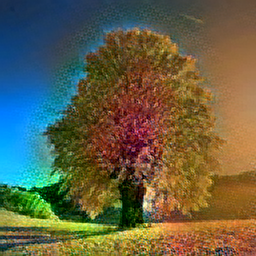

In [12]:
test()